In [1]:
# Load parameters from JSON file
import json
with open('notebook_parameters.json', 'r') as f:
    parameters = json.load(f)

# Extract parameters
songs = parameters['songs']
playlist_name = parameters['playlist_name']
playlist_description = parameters['playlist_description']
auth_callback_url = parameters['auth_callback_url']

# Monkey patch the input function to return the auth URL when needed
original_input = input

def patched_input(prompt=''):
    print(f"Input requested: {prompt}")
    # If this looks like it's asking for the auth callback URL
    if 'url' in prompt.lower() or 'callback' in prompt.lower() or 'http' in prompt.lower():
        print(f"Automatically providing auth callback URL: {auth_callback_url}")
        return auth_callback_url
    # For any other input request, just return a default value
    return 'default_input'

# Replace the built-in input function with our patched version
import builtins
builtins.input = patched_input
# Also patch raw_input for Python 2 compatibility
try:
    builtins.raw_input = patched_input
except AttributeError:
    pass

print(f"Loaded parameters: {len(songs)} songs, playlist name: {playlist_name}")


Loaded parameters: 3 songs, playlist name: Generated2


Setting Up The Database

In [2]:
# Installing packages
!pip3 install watermark


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import of libraries

# System libraries
import re
import unicodedata
import itertools

# Library for file manipulation
import pandas as pd
import numpy as np
import pandas

# Data visualization
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt

# Machine learning
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Configuration for graph width and layout
sns.set_theme(style='whitegrid')
palette='viridis'

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

# Python version
from platform import python_version
print('Python version in this Jupyter Notebook:', python_version())

# Load library versions
import watermark

# Library versions
%reload_ext watermark
%watermark -a "Library versions" --iversions

Python version in this Jupyter Notebook: 3.13.1
Author: Library versions

pandas    : 2.2.3
json      : 2.0.9
sklearn   : 1.6.1
platform  : 1.0.8
matplotlib: 3.10.1
plotly    : 6.0.1
numpy     : 2.2.4
watermark : 2.5.0
seaborn   : 0.13.2
re        : 2.2.1



In [4]:
# Database
df = pd.read_csv("spotify_songs.csv")

In [5]:
# Viewing first 5 data
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [6]:
# Info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [7]:
# Type data
df.dtypes

track_id                     object
track_name                   object
track_artist                 object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
dtype: object

In [8]:
# Viewing rows and columns
df.shape

(32833, 23)

In [9]:
# Copy data
data = df.copy()

Exploratory Data Analysis

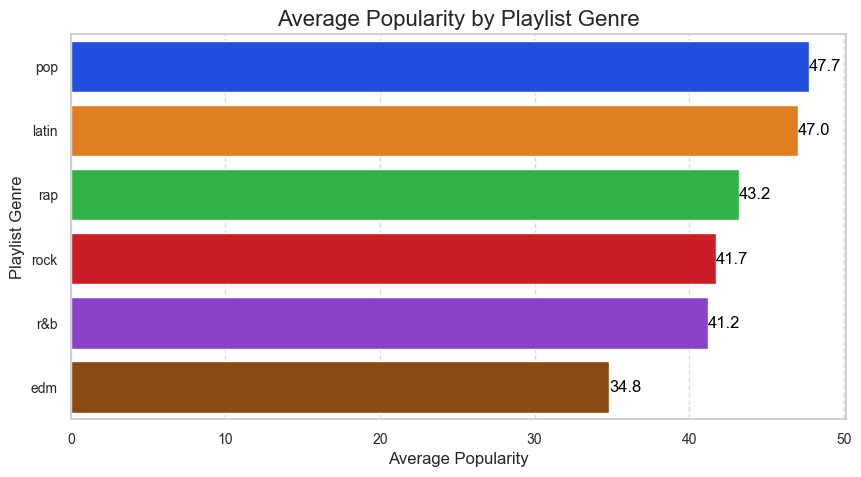

In [10]:
# Average popularity by playlist genre, sorted in descending order
playlist_popularity = data.groupby('playlist_genre')['track_popularity'].mean().sort_values(ascending=False)

# Plotting with improvements
plt.figure(figsize=(10, 5))
sns.barplot(x=playlist_popularity.values, y=playlist_popularity.index, palette='bright')

# Adding data labels
for index, value in enumerate(playlist_popularity.values):
    plt.text(value, index, f'{value:.1f}', va='center', ha='left', color='black')

# Enhancing readability
plt.title('Average Popularity by Playlist Genre', fontsize=16)
plt.xlabel('Average Popularity', fontsize=12)
plt.ylabel('Playlist Genre', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines for comparison
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

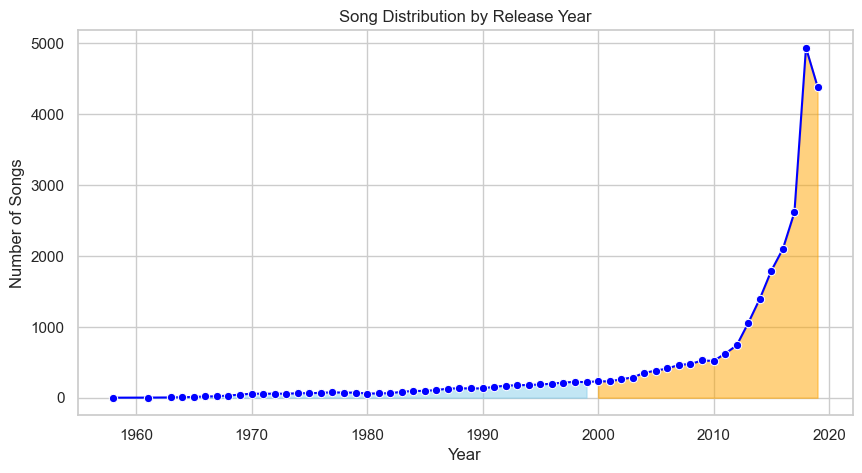

In [11]:
# Assuming your DataFrame is named df and has a 'track_album_release_date' column
data['year'] = pd.to_datetime(data['track_album_release_date'], errors='coerce').dt.year

# Counting the number of songs released each year
yearly_tracks = data['year'].value_counts().sort_index()

# Now, proceed with the rest of your code:
# Removing the most recent year if it's incomplete
yearly_tracks = yearly_tracks[yearly_tracks.index < 2023]  # Adjust the year based on your dataset

# Smoothing the trend with a rolling average
yearly_tracks_smoothed = yearly_tracks.rolling(window=3, center=True).mean()

# Plotting the smoothed trend with annotations and color coding
plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_tracks_smoothed.index, y=yearly_tracks_smoothed.values, marker='o', color='blue')
plt.title('Song Distribution by Release Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.grid(True)

# Adding annotations for key points
max_year = yearly_tracks.idxmax()
max_value = yearly_tracks.max()
plt.annotate(f'Maximum in {max_year}', xy=(max_year, max_value), xytext=(max_year-10, max_value + 500),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

# Color coding different eras
plt.fill_between(yearly_tracks_smoothed.index, yearly_tracks_smoothed.values, where=yearly_tracks_smoothed.index < 2000, color='skyblue', alpha=0.5)
plt.fill_between(yearly_tracks_smoothed.index, yearly_tracks_smoothed.values, where=yearly_tracks_smoothed.index >= 2000, color='orange', alpha=0.5)

plt.show()

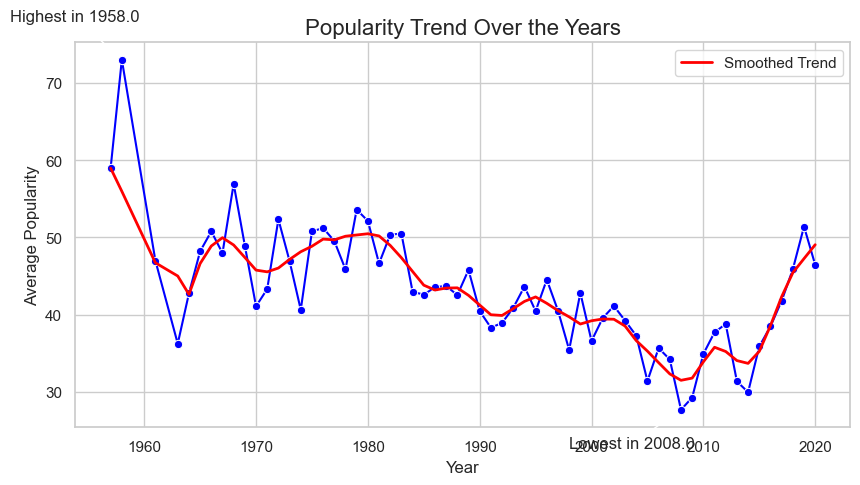

In [12]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Assuming your DataFrame is named df and has 'track_popularity' and 'track_album_release_date' columns
#df['year'] = pd.to_datetime(df['track_album_release_date'], errors='coerce').dt.year

# Calculate the average popularity for each year
yearly_popularity = data.groupby('year')['track_popularity'].mean()

# Calculate smoothed trend line
smoothed = lowess(yearly_popularity.values, yearly_popularity.index, frac=0.1)

plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_popularity.index, y=yearly_popularity.values, marker='o', color='blue')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', lw=2, label='Smoothed Trend')
plt.title('Popularity Trend Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Popularity', fontsize=12)

# Annotate the peak and trough
max_year = yearly_popularity.idxmax()
max_value = yearly_popularity.max()
plt.annotate(f'Highest in {max_year}', xy=(max_year, max_value), xytext=(max_year-10, max_value+5),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

min_year = yearly_popularity.idxmin()
min_value = yearly_popularity.min()
plt.annotate(f'Lowest in {min_year}', xy=(min_year, min_value), xytext=(min_year-10, min_value-5),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.legend()
plt.show()

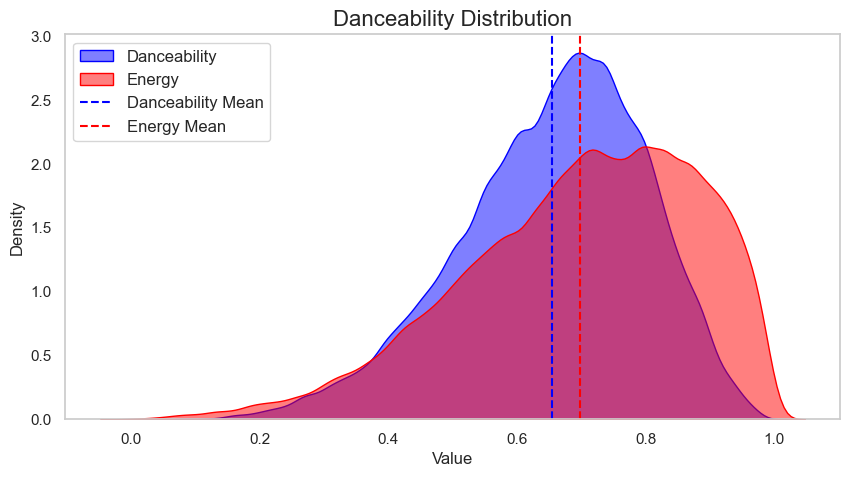

In [13]:
# plot Danceability Distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(df['danceability'], shade=True, label='Danceability', color='blue', alpha=0.5, bw_adjust=0.7)
sns.kdeplot(df['energy'], shade=True, label='Energy', color='red', alpha=0.5, bw_adjust=0.7)
plt.axvline(df['danceability'].mean(), color='blue', linestyle='--', label='Danceability Mean')
plt.axvline(df['energy'].mean(), color='red', linestyle='--', label='Energy Mean')
plt.title('Danceability Distribution', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.grid(False)
plt.show()

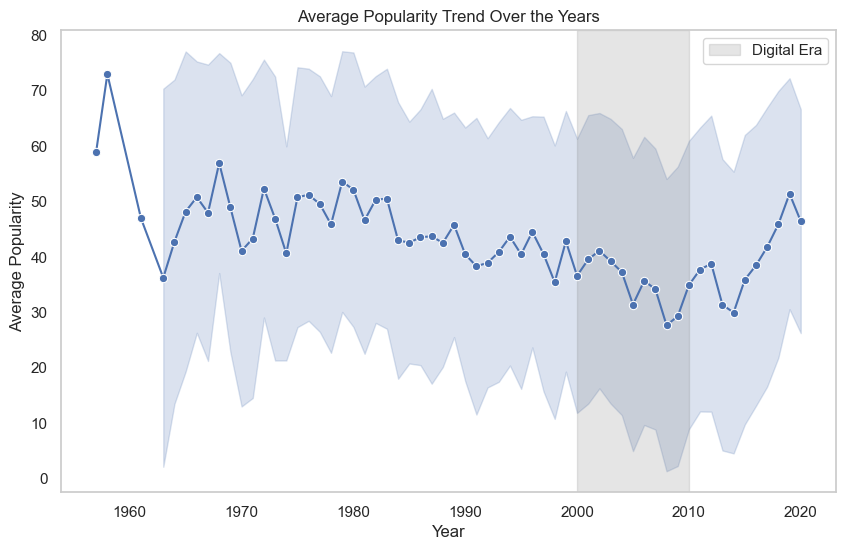

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='track_popularity', data=data, ci='sd', marker='o')
plt.axvspan(2000, 2010, color='gray', alpha=0.2, label='Digital Era')
plt.title('Average Popularity Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.legend()
plt.grid(False)
plt.show()

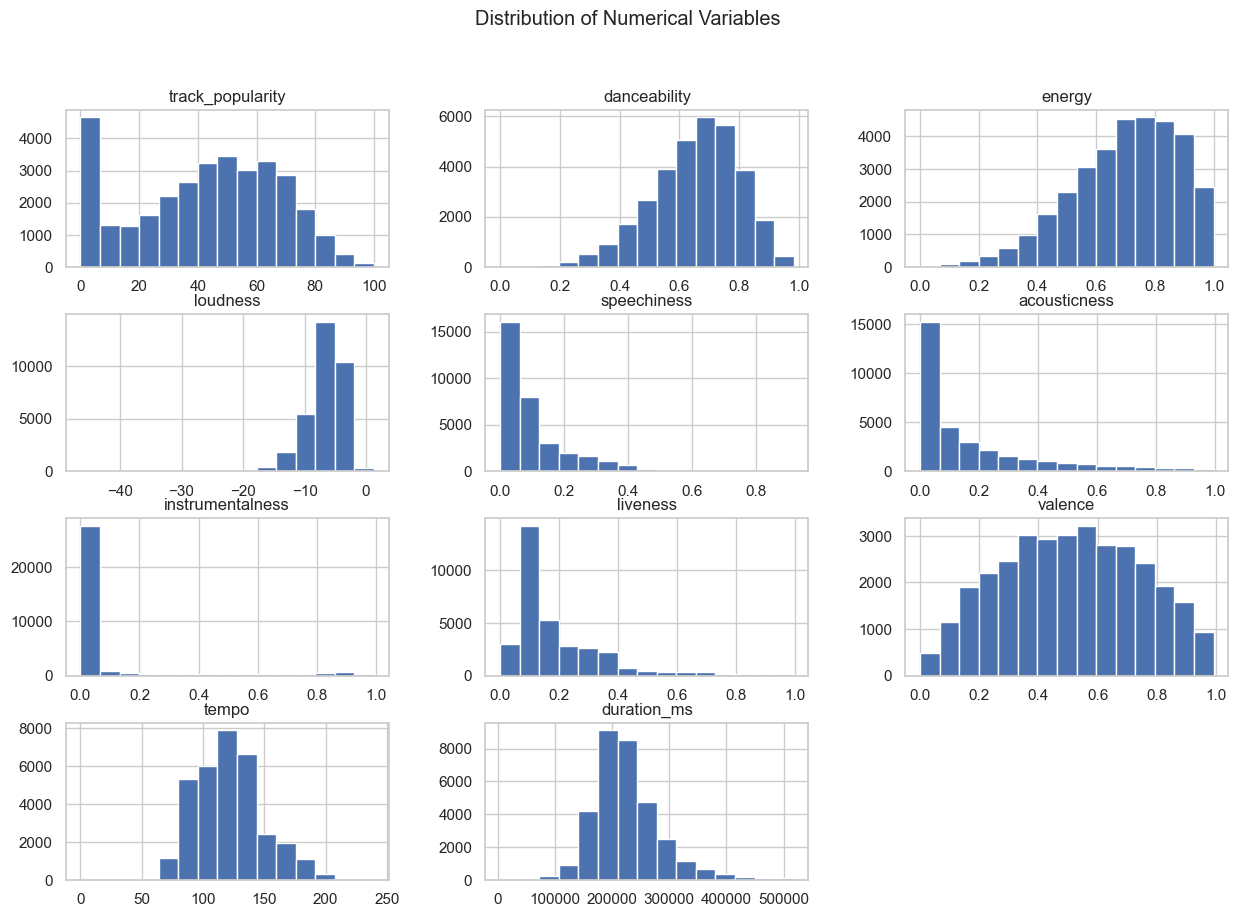


playlist_genre
edm      6043
rap      5746
pop      5507
r&b      5431
latin    5155
rock     4951
Name: count, dtype: int64

track_artist
Martin Garrix                161
Queen                        136
The Chainsmokers             123
David Guetta                 110
Don Omar                     102
Drake                        100
Dimitri Vegas & Like Mike     93
Calvin Harris                 91
Hardwell                      84
Kygo                          83
Name: count, dtype: int64


In [15]:
numerical_columns = ['track_popularity', 'danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

df[numerical_columns].hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

# Frequency of categorical variables
print()
print(df['playlist_genre'].value_counts())

# Top 10 most frequent artists
print()
print(df['track_artist'].value_counts().head(10))

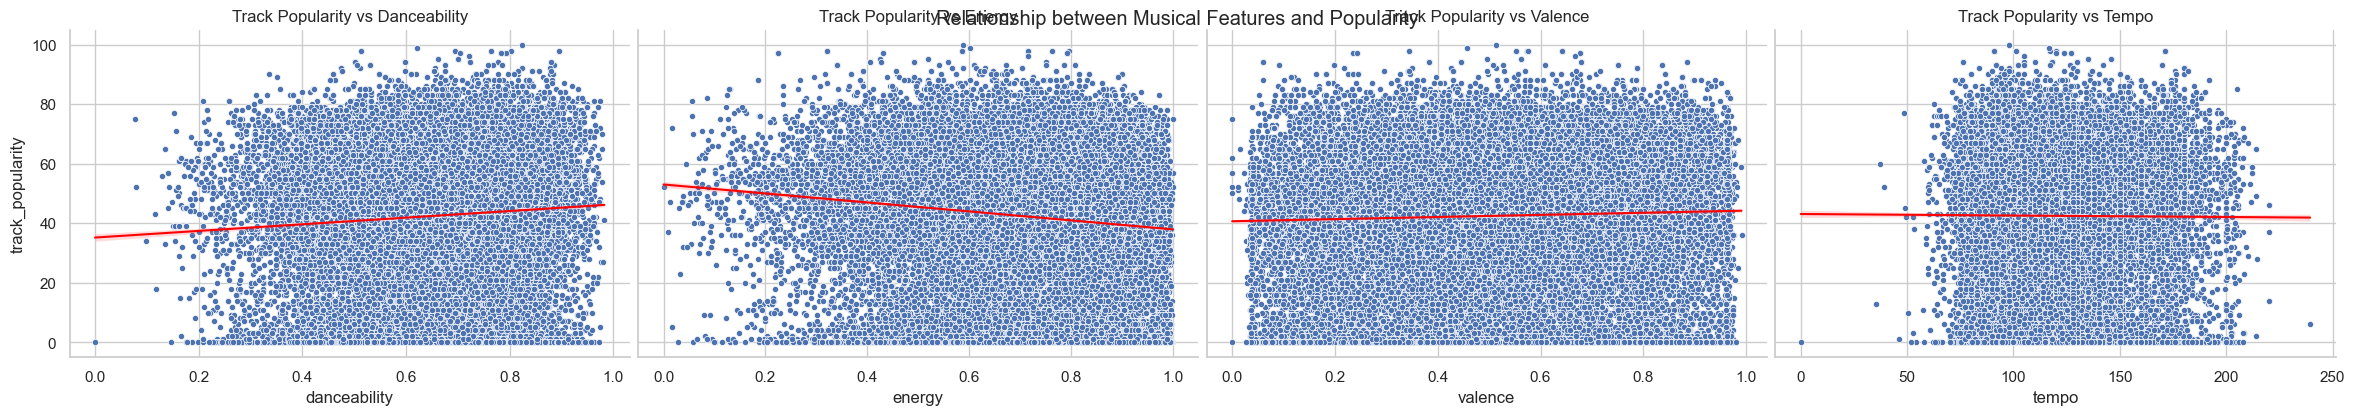

In [16]:
# Creating the pairplot with scatter plots
g = sns.pairplot(df,
                 x_vars=['danceability', 'energy', 'valence', 'tempo'],
                 y_vars='track_popularity',
                 height=4,
                 aspect=1.5,  # Aspect ratio to make the plots wider
                 kind='scatter',  # Keep scatter plot to customize points
                 plot_kws={'s': 20, 'edgecolor': 'w', 'linewidth': 0.5}  # Customize the point size and edges
)

# Manually adding regression lines
for ax in g.axes.flat:
    # Ensure we access the correct x and y data for the regression plot
    sns.regplot(
        x=ax.collections[0].get_offsets()[:, 0],  # Extracting x data from scatter plot
        y=ax.collections[0].get_offsets()[:, 1],  # Extracting y data from scatter plot
        ax=ax,
        scatter=False,  # Hide the scatter plot in the regplot to avoid duplication
        color='red',
        line_kws={'linewidth': 1.5}  # Customize the regression line width
    )

# Adding titles for each subplot
for ax, feature in zip(g.axes.flat, ['Danceability', 'Energy', 'Valence', 'Tempo']):
    ax.set_title(f'Track Popularity vs {feature}')

# Adding a general title for the entire figure
plt.suptitle('Relationship between Musical Features and Popularity', y=1.02)

# Display the plot
plt.show()

Train Test Split

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Splitting the dataset into training and testing
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

print("Viewing training x_train", train_data.shape)
print("Viewing test test_data", test_data.shape)

Viewing training x_train (24624, 23)
Viewing test test_data (8209, 23)


Creation Of Interaction Matrix

In [18]:
# Converting to numpy matrix interaction_matrix_matrix = interaction_matrix.values
interaction_matrix = train_data.pivot_table(index='playlist_id', columns='track_id', values='track_popularity').fillna(0)

Hyperparameter Tuning --> Finding K-value

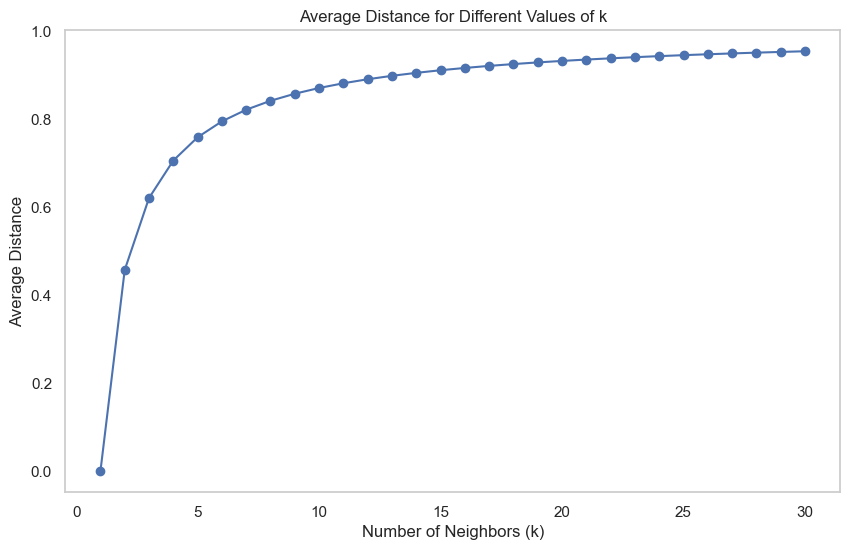

Best value of k: 1


In [19]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

# List of k values to test
k_values = list(range(1, 31))

# Metric to store the results
mean_distances = []

# Loop to find the best k
for k in k_values:
    model = NearestNeighbors(n_neighbors=k, metric='cosine')
    model.fit(interaction_matrix)

    # Compute the distances and indices of the nearest neighbors
    distances, indices = model.kneighbors(interaction_matrix)

    # Calculate the average distance to the nearest neighbors
    mean_distance = np.mean(distances)
    mean_distances.append(mean_distance)

# Plotting the average distance metric for different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_distances, marker='o')
plt.title('Average Distance for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Distance')
plt.grid(False)
plt.show()

# Find the best k (the one that minimizes the average distance)
best_k = k_values[np.argmin(mean_distances)]
print(f"Best value of k: {best_k}")

#Collaborative Filtering Based Recommendation Model

In [20]:
# Adjusting k to test a larger value
model = NearestNeighbors(n_neighbors=best_k, metric='cosine')
model.fit(interaction_matrix)

NearestNeighbors(metric='cosine', n_neighbors=1)

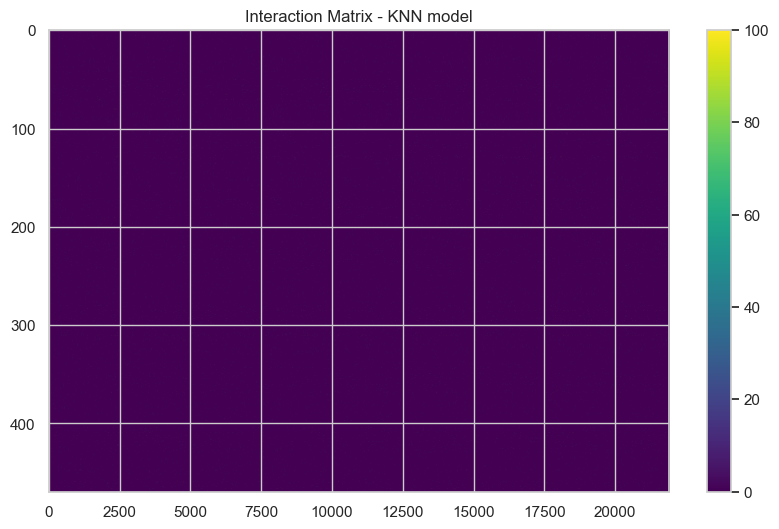

In [21]:
# Plotting the Interaction Matrix
plt.figure(figsize=(10, 6))
plt.imshow(interaction_matrix, aspect='auto', cmap='viridis')
plt.title('Interaction Matrix - KNN model')
plt.colorbar()
plt.show()

#Making Recommendations

In [22]:
data.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,2019.0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,2019.0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,2019.0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,2019.0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,2019.0


In [23]:
# Predefined song to base recommendations on
# Replace with the song you want to start with
default_song_name = "space shuttle"

def recommend_songs(df, model, interaction_matrix, song_name=default_song_name, k=10):
    # Find the playlist(s) that contain the predefined song
    song_playlists = df[df['track_name'].str.contains(song_name, case=False, na=False)]['playlist_id'].unique()

    if len(song_playlists) == 0:
        print("Song not found in the dataset.")
        return

    # Get the index of the first playlist where the song was found
    playlist_id = song_playlists[0]

    # Get unique playlist IDs and their corresponding indices in interaction_matrix
    unique_playlists = df['playlist_id'].unique()

    if playlist_id not in unique_playlists:
        print("Playlist ID not found in unique playlists.")
        return

    playlist_index = np.where(unique_playlists == playlist_id)[0][0]

    # Find similar playlists using KNN
    try:
        # If interaction_matrix is a DataFrame, use .iloc to get the row
        if isinstance(interaction_matrix, pd.DataFrame):
            distances, indices = model.kneighbors(interaction_matrix.iloc[playlist_index].values.reshape(1, -1), n_neighbors=k+1)
        else:
            distances, indices = model.kneighbors(interaction_matrix[playlist_index].reshape(1, -1), n_neighbors=k+1)
    except IndexError:
        print("Playlist index is out of bounds in the interaction matrix.")
        return

    # Remove the index of the original playlist
    similar_playlists = indices.flatten()[1:]  # Ignoring the first one, which is the original playlist

    # Identify songs to recommend
    original_playlist_tracks = set(df[df['playlist_id'] == playlist_id]['track_id'])
    recommended_tracks = set()

    for idx in similar_playlists:
        similar_playlist_id = unique_playlists[idx]
        similar_playlist_tracks = set(df[df['playlist_id'] == similar_playlist_id]['track_id'])
        recommended_tracks.update(similar_playlist_tracks - original_playlist_tracks)

    # Display the recommended songs
    if recommended_tracks:
        recommended_tracks_info = df[df['track_id'].isin(recommended_tracks)][['track_name', 'track_artist']].drop_duplicates()
        print("Recommended songs")
        print(recommended_tracks_info)
    else:
        print("No new songs to recommend.")

# Example usage
# Assuming df, model, and interaction_matrix are already defined
print("Selected Song :- ", default_song_name)
recommend_songs(df, model, interaction_matrix)

Selected Song :-  space shuttle
Recommended songs
                                          track_name        track_artist
130                                             Stay                Zedd
147                  It Ain’t Me (with Selena Gomez)                Kygo
150                                            Roses    The Chainsmokers
323                               More Than You Know  Axwell /\ Ingrosso
457    MIC Drop (feat. Desiigner) [Steve Aoki Remix]                 BTS
...                                              ...                 ...
23893                                  What You Need               BAYNK
23895                  Dark Days - Sofi Tukker Remix       Local Natives
23897            At My Best (feat. Hailee Steinfeld)   Machine Gun Kelly
23901                                  Love Yourself       Justin Bieber
23902                          We Don't Talk Anymore        Charlie Puth

[731 rows x 2 columns]


Euclidean Distance

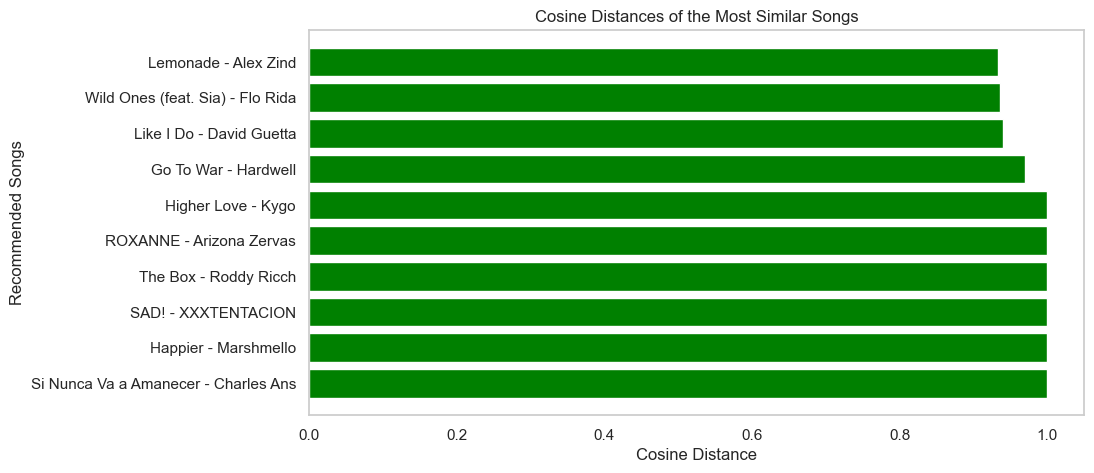

In [24]:
from sklearn.metrics.pairwise import cosine_distances

def plot_distance_music(interaction_matrix, df, playlist_index, k=10):
    # Calculate the cosine distance between the selected playlist and all others
    if isinstance(interaction_matrix, pd.DataFrame):
        cosine_distances_array = cosine_distances(interaction_matrix.iloc[playlist_index].values.reshape(1, -1), interaction_matrix)
    else:
        cosine_distances_array = cosine_distances(interaction_matrix[playlist_index].reshape(1, -1), interaction_matrix)

    # Sort the playlists based on the cosine distance
    sorted_indices = cosine_distances_array.argsort().flatten()

    # Ignore the first index as it will be the playlist itself
    similar_playlists = sorted_indices[1:k+1]

    # Extract the cosine distances of the recommended playlists
    similar_playlists_distances = cosine_distances_array.flatten()[similar_playlists]

    # Map the most popular songs from each similar playlist
    music_names = []
    for idx in similar_playlists:
        playlist_id = df['playlist_id'].unique()[idx]
        popular_music = df[df['playlist_id'] == playlist_id].sort_values(by='track_popularity', ascending=False).iloc[0]
        music_names.append(f"{popular_music['track_name']} - {popular_music['track_artist']}")

    # Plot the cosine distances
    plt.figure(figsize=(10, 5))
    plt.barh(music_names, similar_playlists_distances, color='green')
    plt.xlabel('Cosine Distance')
    plt.ylabel('Recommended Songs')
    plt.title('Cosine Distances of the Most Similar Songs')
    plt.gca().invert_yaxis()  # Invert y-axis so the most similar song is at the top
    plt.grid(False)
    plt.show()

# Example usage
playlist_index = 1  # Replace with the index of the playlist you want to analyze
plot_distance_music(interaction_matrix, df, playlist_index, k=10)

Recommendation system - Group songs into clusters based on their characteristics and recommend songs within these clusters

In [25]:
# Database
data = pd.read_csv("spotify_songs.csv")
data.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [26]:
# 1. Select the relevant features for clustering
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

X = data[features]

In [27]:
# Scaling data
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Viewing
scaler

StandardScaler()

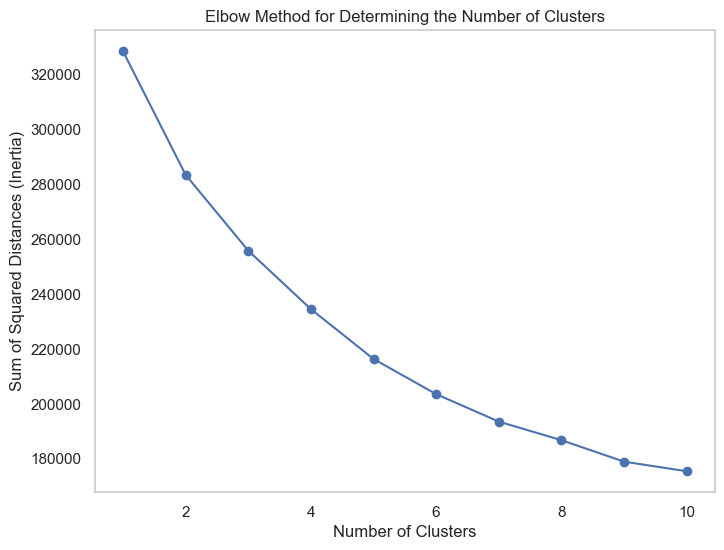

In [28]:
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the elbow method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Determining the Number of Clusters')
plt.grid(False)
plt.show()

In [29]:
# 4. Apply K-Means with the chosen number of clusters
# Assume the optimal number of clusters is 4 (adjust as per the elbow plot)
kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(X_scaled)
kmeans

KMeans(n_clusters=4, random_state=42)

In [30]:
# Viewing total cluster
data.cluster_kmeans.value_counts()

cluster_kmeans
0    13970
2    10837
1     5418
3     2608
Name: count, dtype: int64

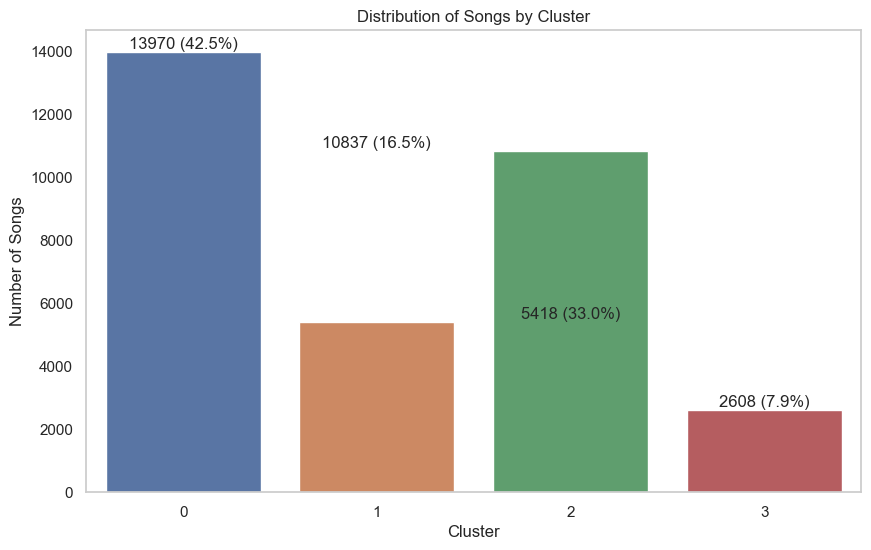

In [31]:
# Count of songs in each cluster
cluster_counts = data['cluster_kmeans'].value_counts().sort_values(ascending=False)

# Calculate the percentage of each cluster
total_songs = cluster_counts.sum()
cluster_percentages = (cluster_counts / total_songs) * 100

# Plot the distribution of clusters with percentages
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='deep')
plt.xlabel('Cluster')
plt.ylabel('Number of Songs')
plt.title('Distribution of Songs by Cluster')

# Adding data labels on top of bars
for index, value in enumerate(cluster_counts):
    plt.text(index, value + 100, f'{value} ({cluster_percentages[index]:.1f}%)', ha='center', fontsize=12)

plt.grid(False)
plt.show()

PCA

In [32]:
from sklearn.decomposition import PCA

# 2. Perform PCA Analysis
# Initialize the PCA model specifying the number of components to reduce to (in this case, 2 components).
pca = PCA(n_components=2)

# Apply PCA on the scaled feature set X_scaled and transform the data into the new 2-dimensional space.
X_pca = pca.fit_transform(X_scaled)

# Output the PCA model object, which contains information such as the amount of variance explained by each principal component.
pca

PCA(n_components=2)

Cluster Visualization

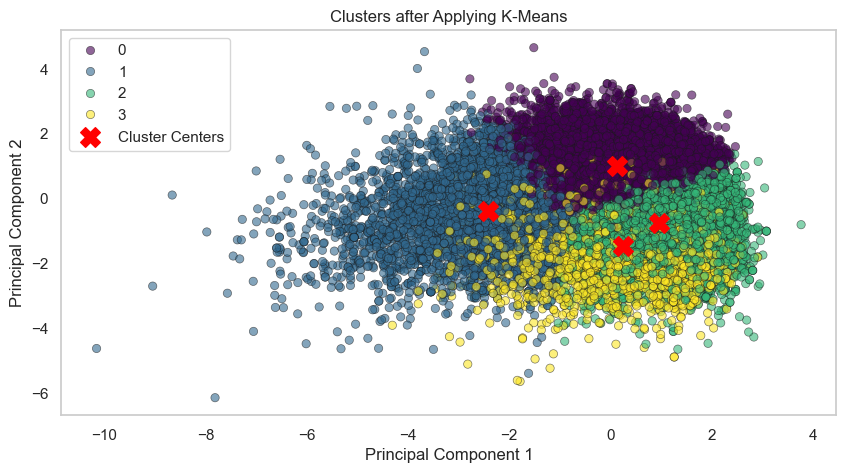

In [33]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
data['cluster_kmeans'] = clusters

# Plotting the clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0],
                y=X_pca[:, 1],
                hue=data['cluster_kmeans'],
                palette='viridis',
                alpha=0.6,
                edgecolor='k')

# Adding the cluster centers
centers = kmeans.cluster_centers_
# Projecting the centers to the 2D PCA space
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            c='red',
            s=200,
            marker='X',
            label='Cluster Centers')

plt.title('Clusters after Applying K-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(False)
plt.show()

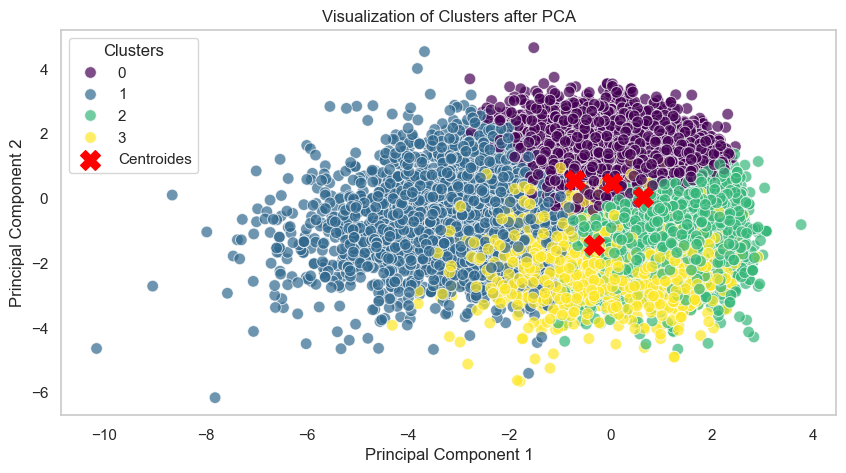

In [34]:
# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['cluster_kmeans'], palette='viridis', s=70, alpha=0.7)

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroides')

plt.title('Visualization of Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.grid(False)
plt.show()

In [35]:
# Assuming you want to calculate the mean of features for cluster 2 (since `== 2` is used)
cluster_1_features = data[data['cluster_kmeans'] == 0][features].mean()
print("Mean of Features for Cluster 0:")
print(cluster_1_features)
print()

# Assuming you want to calculate the mean of features for cluster 2 (since `== 2` is used)
cluster_2_features = data[data['cluster_kmeans'] == 1][features].mean()
print("Mean of Features for Cluster 1:")
print(cluster_2_features)
print()

# Assuming you want to calculate the mean of features for cluster 2 (since `== 2` is used)
cluster_3_features = data[data['cluster_kmeans'] == 2][features].mean()
print("Mean of Features for Cluster 2:")
print(cluster_3_features)
print()

# Assuming you want to calculate the mean of features for cluster 2 (since `== 2` is used)
cluster_4_features = data[data['cluster_kmeans'] == 3][features].mean()
print("Mean of Features for Cluster 3:")
print(cluster_4_features)
print()

Mean of Features for Cluster 0:
danceability             0.749967
energy                   0.705715
loudness                -6.356785
speechiness              0.135034
acousticness             0.149064
instrumentalness         0.011371
liveness                 0.163004
valence                  0.650860
tempo                  114.067444
duration_ms         220058.703651
dtype: float64

Mean of Features for Cluster 1:
danceability             0.609132
energy                   0.436545
loudness               -10.374419
speechiness              0.091388
acousticness             0.497412
instrumentalness         0.084702
liveness                 0.158093
valence                  0.399183
tempo                  112.972669
duration_ms         226330.339978
dtype: float64

Mean of Features for Cluster 2:
danceability             0.553642
energy                   0.799628
loudness                -5.305196
speechiness              0.087260
acousticness             0.072985
instrumentalness      

Making Recommendations - 2

In [36]:
def recommend_songs_by_cluster_kmeans(song_name, data):
    # Search for the selected song in the dataset, ignoring case and handling missing values
    selected_song = data[data['track_name'].str.contains(song_name, case=False, na=False)]

    # If the song is not found, display a message and exit the function
    if selected_song.empty:
        print("Song not found.")
        return None

    # Retrieve the cluster to which the selected song belongs
    cluster = selected_song['cluster_kmeans'].values[0]

    # Find all songs that belong to the same cluster as the selected song
    recommended_songs = data[data['cluster_kmeans'] == cluster]

    # Exclude the selected song from the recommendations
    recommended_songs = recommended_songs[recommended_songs['track_name'] != selected_song['track_name'].values[0]]

    # Return the 'track_id', 'track_name' and 'track_artist' columns, limited to the top 25 recommendations
    return recommended_songs[['track_id', 'track_name', 'track_artist']].head(5)

In [37]:
# Example of usage
# Replace with the name of the song you want to use as the base for recommendations
# song_name = "All the Time - Don Diablo Remix"
# top_recommendations_kmeans = recommend_songs_by_cluster_kmeans(song_name, data)
# top_recommendations_kmeans

Creating a Playlist and Adding Recommended Songs

In [38]:
# !pip3 install spotipy
import playlist_generator

In [39]:
recommended_tracks = {}
for song_name in songs:
    top_recommendations_kmeans = recommend_songs_by_cluster_kmeans(song_name, data)
    top_recommendations_kmeans
    # Convert into a dictionary with keys as track_id and value as track_name
    temp_dict = top_recommendations_kmeans.to_dict('list')
    for i in range(len(temp_dict['track_id'])):
        recommended_tracks[temp_dict['track_id'][i]] = temp_dict['track_name'][i]
        
playlist = playlist_generator.create_playlist(playlist_name, playlist_description)
playlist_generator.add_songs(recommended_tracks, playlist)
    

In [40]:
# Convert into a dictionary with keys as track_id and value as track_name
# temp_dict = top_recommendations_kmeans.to_dict('list')
# recommended_tracks = {}
# for i in range(len(temp_dict['track_id'])):
#   recommended_tracks[temp_dict['track_id'][i]] = temp_dict['track_name'][i]

# recommended_tracks

In [41]:
# playlist_name = input("Enter a Playlist Name : ")
# playlist_description = input("Enter the Description of the playlist : ")

In [42]:
# This will ask for redirected url the first time you run this --> To get the url, run the file, playlist_generator.py on the terminal and login
# After logging in, paste the redirected url back on this page
# Only happens first time
# playlist = playlist_generator.create_playlist(playlist_name, playlist_description)

In [43]:
# playlist_generator.add_songs(recommended_tracks, playlist)